# Predicting NDVI trends with Gradient Boosting Regression Trees

## Overview

- **Key ideas:**
    - Learning some cool things. Just a test!
    - Intensive time consuming operations that use a lot of RAM memory when doing hyper parameter grid search with Bayesian optimization. Run this notebook in aerossol server.
    - The target is given by the decadal variations of NDVI (trends). The initial features obtained here are the following: 
        - (01) `LAT` Latitude; 
        - (02) `LON` Longitude; 
        - (03) `ELEV` Elevation; 
        - (04) `LC` Land class for 2015;
        - (05) `LC` Counts of annual land class changes from 2001 until 2015;
        - (06) `P` Mean precipitation;
        - (07) `P` Standard deviation of precipitation;
        - (08) `P` Long term trends of precipitation;
        - (09) `TMAX` Mean maximum 2-m temperature;
        - (10) `TMAX`Standard deviation of maximum 2-m temperature;
        - (11) `TMAX`Long term trends of maximum 2-m temperature;
        - (12) `TMIN` Mean minimum 2-m temperature;
        - (13) `TMIN` Standard deviation of minimum 2-m temperature;
        - (14) `TMIN` Long term trends of minimum 2-m temperature;
        - (15) `SRAD` Mean downward shortwave radiation flux at the surface;
        - (16) `SRAD` Standard deviation of downward shortwave radiation flux at the surface;
        - (17) `SRAD` Long term trends of downward shortwave radiation flux at the surface;
        - (18) `PDSI` Mean Palmer drought severity index;
        - (19) `PDSI` Standard deviation of Palmer drought severity index;
        - (20) `PDSI` Long term trends of Palmer drought severity index;
        - (21) `NDVI` Mean NDVI;
        - (22) `NDVI` Standard deviation of NDVI.
        - (23) `PAS` Protected areas.
    - Preprocess numeric features separated from the categorical features. We do that by means of [sklearn.compose.ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer). We apply [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to numeric features just for didactic purposes, even though this is not necessary for tree-based learning algorithms. The categorical features are transformed by [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), not being scaled after that. 
    - Use Ridge Regression (RR) as a simple benchmark, optimized with exhaustive grid search over hyper parameters.
    - Use Gradient Boosted Regression Trees (XGBRT) from [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html) ([Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)) with Bayesian optimization over hyper parameters ([skopt.BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)). Export this trained model.
    - Here we analyze a reduced version of the data set: only instances with statistical significance in NDVI trends, which gives us approximately 5 % of rows in the original matrix.
    - All performance metrics are based on R2 score. 
    - Permutation feature importances for XGBRT model.
    - Partial dependence plots for XGBRT model.
    - Spatial distributions for train-test data split and for relative error prediction.
- **Notes:** 
    - Note that partial dependence plots assume that the target features are independent from the complement features, and this assumption is often violated in practice.
- **References:**
    - Natekin, A. and Knoll, A. (2013). [Gradient boosting machines, a tutorial](https://www.frontiersin.org/articles/10.3389/fnbot.2013.00021/full). Frontiers in neurorobotics, 7:21.
    - [Sckit-Learn: Exhaustive search over specified parameter values for an estimator](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
    - [Sckit-Learn: Column Transformer with Mixed Types](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html).
    - [XGBoost Parameters](https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst).
    - [Scikit-Optimize: Scikit-learn hyperparameter search wrapper](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html#sphx-glr-auto-examples-sklearn-gridsearchcv-replacement-py).

## Initial setup

In [1]:
# Load packages.
import sys
import warnings
import sklearn 
import joblib

import numpy as np
import pandas as pd
import xarray as xr 
import sklearn as skl
import matplotlib as mpl
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.base import clone
from sklearn.inspection import permutation_importance, partial_dependence
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
print(">>> Versions:")
print("* numpy:", np.__version__)
print("* pandas:", pd.__version__)
print("* xarray:", xr.__version__)
print("* scikit-learn:", skl.__version__)
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPUs: $(nproc)"

>>> Versions:
* numpy: 1.19.1
* pandas: 1.1.1
* xarray: 0.16.0
* scikit-learn: 0.23.2

>>> Computer:
* Hostname: n007
* User: sandroal
* Directory: /work/sandroal/notebooks/modelling
* Date: Wed Dec  9 14:37:12 BRST 2020
* CPUs: 40


In [3]:
%%time

# My repository.
repository = "/work/sandroal/cdlearn/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

CPU times: user 2.52 s, sys: 432 ms, total: 2.96 s
Wall time: 3.93 s


In [4]:
# Where figures will be put.
FIG_FOLDER = "/work/sandroal/images/modelling/"

# Final results.
save_fig = True

# South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Decadal variation in slopes.
factor = 120 * 2

# Significance global threshold (decadal variation).
u = 0.0192

## Load data matrix

In [5]:
%%time

# Data file path.
ppdatafp = "/work/sandroal/data_sets/FEATURES/ndvi_trends.csv"

# Load data in a pandas DataFrame object.
df_matrix = pd.read_csv(ppdatafp)

# Show it.
print("=== Data with and without statistical significance in NDVI trends ===")
print("\n>>> Columns:", df_matrix.columns)
print("\n>>> Shape", df_matrix.shape)
print()
df_matrix.head()

=== Data with and without statistical significance in NDVI trends ===

>>> Columns: Index(['lat', 'lon', 'elev', 'lclass_2015', 'lclass_2001_2015_dcount',
       'p_mean', 'p_std', 'p_slope', 'tmax_mean', 'tmax_std', 'tmax_slope',
       'tmin_mean', 'tmin_std', 'tmin_slope', 'srad_mean', 'srad_std',
       'srad_slope', 'pdsi_mean', 'pdsi_std', 'pdsi_slope', 'ndvi_mean',
       'ndvi_std', 'protected_area', 'ndvi_slope'],
      dtype='object')

>>> Shape (228646, 24)

CPU times: user 1.4 s, sys: 120 ms, total: 1.52 s
Wall time: 1.53 s


,lat,lon,elev,lclass_2015,lclass_2001_2015_dcount,p_mean,p_std,p_slope,tmax_mean,tmax_std,...,srad_mean,srad_std,srad_slope,pdsi_mean,pdsi_std,pdsi_slope,ndvi_mean,ndvi_std,protected_area,ndvi_slope
0,-55.875000,-67.208333,26.987129,0,0,0.0,0.0,0.0,8.587447,3.013888,...,94.502431,62.982034,0.0,-0.984239,2.501392,-2.016802,0.625084,0.057361,1,0.007261
1,-55.875000,-67.125000,188.500253,9,0,0.0,0.0,0.0,8.217287,2.945910,...,93.347908,62.116514,0.0,-0.970170,2.470640,-1.943672,0.630312,0.051792,1,-0.017732
2,-55.708333,-67.458333,194.751892,0,0,0.0,0.0,0.0,8.102003,3.111487,...,88.917352,59.173952,0.0,-0.890400,2.401116,-1.850004,0.633719,0.084883,1,0.002685
3,-55.708333,-67.375000,74.248263,0,0,0.0,0.0,0.0,8.356106,3.116774,...,91.725914,60.506976,0.0,-0.954349,2.465468,-1.972234,0.641481,0.087672,1,0.003421
4,-55.708333,-67.291667,10.247289,0,0,0.0,0.0,0.0,8.532316,3.118584,...,93.856327,61.865061,0.0,-0.982610,2.496296,-2.000002,0.667822,0.085308,1,-0.004208


In [6]:
# Summary statistics.
df_matrix.drop(labels=["lat", "lon", "lclass_2015", "protected_area"], axis="columns").describe()

,elev,lclass_2001_2015_dcount,p_mean,p_std,p_slope,tmax_mean,tmax_std,tmax_slope,tmin_mean,tmin_std,tmin_slope,srad_mean,srad_std,srad_slope,pdsi_mean,pdsi_std,pdsi_slope,ndvi_mean,ndvi_std,ndvi_slope
count,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000
mean,585.551326,0.223275,63.712404,50.623752,0.421719,27.103458,2.366252,0.283127,15.789759,2.216654,0.310940,182.852251,37.781894,-0.197442,-0.025660,2.777918,-0.137154,0.625376,0.071869,0.002138
std,912.754930,0.666124,37.953218,23.022120,2.050873,6.198829,1.756277,0.295784,7.023440,1.446057,0.283527,25.503492,19.177504,6.928412,0.887116,0.491867,1.194424,0.230013,0.033023,0.009460
min,1.000000,0.000000,0.000000,0.000000,-20.374601,-2.476180,0.501048,-0.701302,-16.666155,0.391691,-0.576002,79.556168,13.136532,-31.351333,-3.432126,0.261838,-5.924686,-0.300002,0.000002,-0.125887
25%,106.000266,0.000000,34.757871,36.263082,0.000000,24.276435,1.130342,0.151899,12.458019,0.880073,0.107780,166.399154,23.707840,-3.660298,-0.558334,2.474363,-0.909088,0.534098,0.051355,-0.002617
50%,265.000000,0.000000,62.647967,52.800910,0.000000,29.928171,1.530255,0.329899,18.498248,1.840865,0.299998,184.691427,30.378333,0.714286,0.106522,2.702161,-0.243017,0.661429,0.068069,0.002303
75%,603.000117,0.000000,88.772142,66.324301,0.895280,31.379107,3.188571,0.480003,21.099398,3.255106,0.509224,199.076537,46.245999,4.166667,0.609541,3.005709,0.543209,0.831446,0.090375,0.007266
max,6478.749815,10.000000,353.047128,183.721048,28.466404,34.783032,7.236874,1.019600,26.232127,6.720710,1.045872,256.847229,94.205595,17.285319,3.477175,79.731226,4.842106,0.916129,0.271057,0.175385


## Preprocess and split data

In [7]:
%%time

# Numeric data (float and int). 
numeric_features = [
    "lclass_2001_2015_dcount",
    "lat", "lon", "elev", 
    "p_mean", "p_std", "p_slope",
    "tmax_mean", "tmax_std", "tmax_slope",
    "tmin_mean", "tmin_std", "tmin_slope", 
    "srad_mean", "srad_std", "srad_slope", 
    "pdsi_mean", "pdsi_std", "pdsi_slope", 
    "ndvi_mean", "ndvi_std"
]

# Categorical data.
categorical_features = ["lclass_2015", "protected_area"]

# Target.
target = ["ndvi_slope"]

# Inputs.
features = categorical_features + numeric_features

# For tree-based models it is not necessary to scale data. 
# We do it here just for learning purposes.
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())] 
)

# One hot encoding.
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder())]
)

# Column-wise transformations by feature type.
preprocessor = ColumnTransformer(
    transformers=[("numeric", numeric_transformer, numeric_features),
                  ("categorical", categorical_transformer, categorical_features)]
)

# Reduce number of instances: only trends with statistical significance
mask_stat_sig = df_matrix.ndvi_slope.abs() >= u
df_matrix = df_matrix[mask_stat_sig]

# Simple train-test split as pandas DataFrame objects.
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df_matrix[features], 
    df_matrix[target], 
    test_size=0.3, 
    stratify=df_matrix.lclass_2015
)

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 26.4 ms


In [8]:
print(">>> All data:")
print("* Positive trends:", np.sum(df_matrix.ndvi_slope > 0))
print("* Negative trends:", np.sum(df_matrix.ndvi_slope < 0))
print("\n>>> Train set:")
print("* Positive trends:", np.sum(df_y_train.ndvi_slope > 0))
print("* Negative trends:", np.sum(df_y_train.ndvi_slope < 0))
print("\n>>> Test set:")
print("* Positive trends:", np.sum(df_y_test.ndvi_slope > 0))
print("* Negative trends:", np.sum(df_y_test.ndvi_slope < 0))

>>> All data:
* Positive trends: 7227
* Negative trends: 4925

>>> Train set:
* Positive trends: 5022
* Negative trends: 3484

>>> Test set:
* Positive trends: 2205
* Negative trends: 1441


CPU times: user 108 ms, sys: 8 ms, total: 116 ms
Wall time: 125 ms


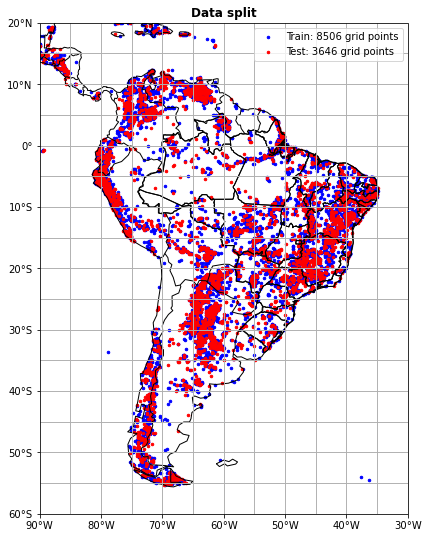

In [9]:
%%time

# Map for train - test split.
sca = 1.10
axgr = cdlearn.maps.south_america(
    figsize=(6 * sca, 12 * sca), 
    nrows_ncols=(1, 1),
    axes_pad=0.50,
    titles=["Data split"],
    cbar_mode="none"
)

# Train.
_ = axgr[0].scatter(
    x=df_x_train["lon"].values, 
    y=df_x_train["lat"].values, 
    s=25,
    marker=".", 
    color="blue",
    label=f"Train: {df_x_train.shape[0]} grid points"
)

# Test.
_ = axgr[0].scatter(
    x=df_x_test["lon"].values, 
    y=df_x_test["lat"].values, 
    s=25,
    marker=".", 
    color="red",
    label=f"Test: {df_x_test.shape[0]} grid points"
)

# Legends.    
_ = axgr[0].legend(loc=1)

## RR model as benchmark

In [10]:
%%time

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model_benchmark = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("model", Ridge())]
)

# Hyper parameters of pipelines can be set using ‘__’.
hparams_grid = {
    "model__alpha": np.power(10, np.linspace(start=-5, stop=5, num=512))
}

# Search for the best model.
search_benchmark = GridSearchCV(
    estimator=model_benchmark, 
    param_grid=hparams_grid, 
    scoring="r2",
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search_benchmark.fit(df_x_train, df_y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed:   38.7s


CPU times: user 25.8 s, sys: 5.05 s, total: 30.8 s
Wall time: 41.3 s


[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:   41.1s finished


In [11]:
# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df = pd.DataFrame(search_benchmark.cv_results_)
print(df.iloc[search_benchmark.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search_benchmark.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                    0.0441467
std_fit_time                                    0.00275069
mean_score_time                                  0.0169148
std_score_time                                 0.000417904
param_model__alpha                                  1.5343
params                {'model__alpha': 1.5342989238563602}
split0_test_score                                 0.487769
split1_test_score                                 0.512452
split2_test_score                                 0.509822
split3_test_score                                 0.529635
split4_test_score                                 0.493505
mean_test_score                                   0.506637
std_test_score                                   0.0148412
rank_test_score                                          1
split0_train_score                                0.517745
split1_train_score                                 0.51176
split2_train_sco

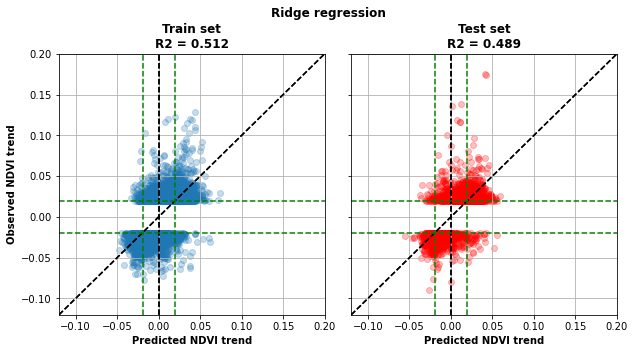

In [12]:
# Scatter plot of train and test scores.
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes = axes.flatten()

# Predictions.
df_y_train_pred = search_benchmark.best_estimator_.predict(df_x_train)
df_y_test_pred = search_benchmark.best_estimator_.predict(df_x_test)

# Train!
axes[0].scatter(df_y_train_pred, df_y_train, alpha=0.25)

# Test.
axes[1].scatter(df_y_test_pred, df_y_test, alpha=0.25, color="red")

# Diagonal, horizontal, and vertical lines.
for axis in axes:
    axis.set_ylim((-0.12, 0.20))
    axis.set_xlim((-0.12, 0.20))
    axis.plot(axes[0].get_xlim(), axes[0].get_xlim(), "--k")
    axis.axvline(ls="--", color="black")
    axis.axvline(ls="--", color="black")
    axis.plot(axis.get_xlim(), axis.get_xlim(), "--k")
    axis.axvline(x=-u, lw=1.5, ls="--", color="green")
    axis.axvline(x=u, lw=1.5, ls="--", color="green")
    axis.axhline(y=-u, lw=1.5, ls="--", color="green")
    axis.axhline(y=u, lw=1.5, ls="--", color="green")

# Adjustments.
axes[0].set_ylabel("Observed NDVI trend", weight="bold")
axes[0].set_xlabel("Predicted NDVI trend", weight="bold")
fig.suptitle("Ridge regression", weight="bold")
axes[1].set_xlabel("Predicted NDVI trend", weight="bold")
axes[0].set_title("Train set\nR2 = %.3f" %(r2_score(df_y_train, df_y_train_pred)), 
                  weight="bold")
axes[1].set_title("Test set\nR2 = %.3f" %(r2_score(df_y_test, df_y_test_pred)), 
                  weight="bold")
axes[0].grid()
axes[1].grid()
plt.subplots_adjust(top=0.85, wspace=0.10)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_rr_predictions.jpg", 
        dpi=200, 
        bbox_inches="tight"
    ) 

## Train XGBRT model with BayesSearchCV

In [13]:
# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model_xgbrt = Pipeline(
    steps=[("preprocessor", clone(preprocessor, safe=True)),
           ("model", xgb.XGBRegressor())]
)

# Bayesian optimization over hyperparameters. Search for the best model.
search_xgbrt = BayesSearchCV(
    estimator=model_xgbrt,
    search_spaces={
        "model__n_estimators": Integer(low=500, high=3000, prior="uniform"),
        "model__max_depth": Integer(low=1, high=30, prior="uniform"),
        "model__learning_rate": Real(low=0.001, high=1.000, prior="log-uniform"),
        "model__objective": Categorical(["reg:pseudohubererror", "reg:squarederror"]),
        "model__subsample": Real(low=0.05, high=0.95, prior="log-uniform"),
        "model__lambda": Real(low=1, high=1000, prior="log-uniform"),
        "model__alpha": Real(low=1, high=1000, prior="log-uniform"),
    },
    n_iter=280,
    scoring="r2",
    n_jobs=-1,
    n_points=7,
    cv=5,
    verbose=0,
    return_train_score=True
)

print(">>> Total iterations (it will take to explore all subspaces):", 
      search_xgbrt.total_iterations)

>>> Total iterations (it will take to explore all subspaces): 1960


**Danger Zone: It can take a lot of time!**

In [14]:
%%time

# Run fit with all sets of parameters.
_ = search_xgbrt.fit(df_x_train, df_y_train)

CPU times: user 6h 11min 55s, sys: 15min 9s, total: 6h 27min 4s
Wall time: 59min 26s


In [15]:
# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df = pd.DataFrame(search_xgbrt.cv_results_)
print(df.iloc[search_xgbrt.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search_xgbrt.best_params_)


>>> Results for best hyper parameters:
split0_test_score                                                      0.757427
split1_test_score                                                      0.737111
split2_test_score                                                      0.746302
split3_test_score                                                      0.758852
split4_test_score                                                      0.737493
mean_test_score                                                        0.747438
std_test_score                                                       0.00934774
rank_test_score                                                               1
split0_train_score                                                     0.864578
split1_train_score                                                     0.858585
split2_train_score                                                     0.860154
split3_train_score                                                     0.862725


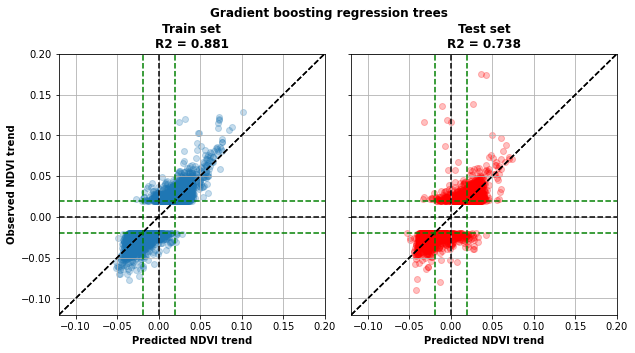

In [16]:
# Scatter plot of train and test scores.
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes = axes.flatten()

# Predictions.
df_y_train_pred = search_xgbrt.best_estimator_.predict(df_x_train)
df_y_test_pred = search_xgbrt.best_estimator_.predict(df_x_test)

# Train!
axes[0].scatter(df_y_train_pred, df_y_train, alpha=0.25)

# Test.
axes[1].scatter(df_y_test_pred, df_y_test, alpha=0.25, color="red")

# Diagonal, horizontal, and vertical lines.
for axis in axes:
    axis.set_ylim((-0.12, 0.20))
    axis.set_xlim((-0.12, 0.20))
    axis.plot(axes[0].get_xlim(), axes[0].get_xlim(), "--k")
    axis.axvline(ls="--", color="black")
    axis.axhline(ls="--", color="black")
    axis.plot(axis.get_xlim(), axis.get_xlim(), "--k")
    axis.axvline(x=-u, lw=1.5, ls="--", color="green")
    axis.axvline(x=u, lw=1.5, ls="--", color="green")
    axis.axhline(y=-u, lw=1.5, ls="--", color="green")
    axis.axhline(y=u, lw=1.5, ls="--", color="green")

# Adjustments.
axes[0].set_ylabel("Observed NDVI trend", weight="bold")
axes[0].set_xlabel("Predicted NDVI trend", weight="bold")
fig.suptitle("Gradient boosting regression trees", weight="bold")
axes[1].set_xlabel("Predicted NDVI trend", weight="bold")
axes[0].set_title("Train set\nR2 = %.3f" %(r2_score(df_y_train, df_y_train_pred)), 
                  weight="bold")
axes[1].set_title("Test set\nR2 = %.3f" %(r2_score(df_y_test, df_y_test_pred)), 
                  weight="bold")
axes[0].grid()
axes[1].grid()
plt.subplots_adjust(top=0.85, wspace=0.10)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_gbrt_xgboost_predictions.jpg", 
        dpi=200, 
        bbox_inches="tight"
    ) 

## Export XGBRT model

In [17]:
%%time

# Where to find it.
file_path = "/work/sandroal/trained_models/xgbrt_ndvi_trends.joblib"

# Export model.
joblib.dump(
    value=search_xgbrt.best_estimator_,
    filename=file_path
)

# Load it again.
final_model = joblib.load(file_path)

# Show it.
print(final_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lclass_2001_2015_dcount',
                                                   'lat', 'lon', 'elev',
                                                   'p_mean', 'p_std', 'p_slope',
                                                   'tmax_mean', 'tmax_std',
                                                   'tmax_slope', 'tmin_mean',
                                                   'tmin_std', 'tmin_slope',
                                                   'srad_mean', 'srad_std',
                                                   'srad_slope', 'pdsi_mean',
                                                   'pdsi_std', 'pdsi_slope',
                                               

## Sign coherence of predictions

CPU times: user 5.81 s, sys: 272 ms, total: 6.08 s
Wall time: 1.24 s


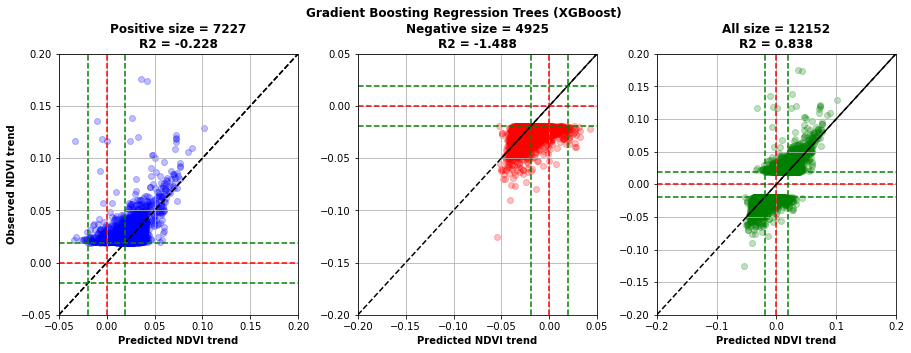

In [18]:
%%time

# Selecting observed signs.
mask_pos = df_matrix.ndvi_slope > 0
mask_neg = df_matrix.ndvi_slope < 0

# Predictions (as numpy array).
y_pred = final_model.predict(df_matrix)

# Make figure.
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

# Positive!
axes[0].scatter(y_pred[mask_pos], df_matrix[target][mask_pos], color="blue", alpha=0.25)

# Negative!
axes[1].scatter(y_pred[mask_neg], df_matrix[target][mask_neg], color="red", alpha=0.25)

# All!
axes[2].scatter(y_pred, df_matrix[target], color="green", alpha=0.25)

# Diagonal, horizontal, and vertical lines.
axes[0].set_ylim((-0.05, 0.20))
axes[0].set_xlim((-0.05, 0.20))
axes[1].set_ylim((-0.20, 0.05))
axes[1].set_xlim((-0.20, 0.05))
axes[2].set_ylim((-0.20, 0.20))
axes[2].set_xlim((-0.20, 0.20))
for axis in axes:
    axis.plot(axes[0].get_xlim(), axes[0].get_xlim(), "--k")
    axis.axvline(ls="--", color="red")
    axis.axhline(ls="--", color="red")
    axis.plot(axis.get_xlim(), axis.get_xlim(), "--k")
    axis.axvline(x=-u, lw=1.5, ls="--", color="green")
    axis.axvline(x=u, lw=1.5, ls="--", color="green")
    axis.axhline(y=-u, lw=1.5, ls="--", color="green")
    axis.axhline(y=u, lw=1.5, ls="--", color="green")
    
# Adjustments.
axes[0].set_ylabel("Observed NDVI trend", weight="bold")
axes[0].set_xlabel("Predicted NDVI trend", weight="bold")
fig.suptitle("Gradient Boosting Regression Trees (XGBoost)", weight="bold")
axes[1].set_xlabel("Predicted NDVI trend", weight="bold")
axes[2].set_xlabel("Predicted NDVI trend", weight="bold")
axes[0].set_title("Positive size = %u\nR2 = %.3f" \
                  %(df_matrix[target][mask_pos].size, r2_score(df_matrix[target][mask_pos], y_pred[mask_pos])), 
                  weight="bold")
axes[1].set_title("Negative size = %u\nR2 = %.3f" \
                  %(df_matrix[target][mask_neg].size, r2_score(df_matrix[target][mask_neg], y_pred[mask_neg])), 
                  weight="bold")
axes[2].set_title("All size = %u\nR2 = %.3f" \
                  %(df_matrix[target].size, r2_score(df_matrix[target], y_pred)), 
                  weight="bold")
axes[0].grid()
axes[1].grid()
axes[2].grid()
plt.subplots_adjust(top=0.85, wspace=0.25)  

if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_gbrt_xgboost_predictions2.jpg", 
        dpi=200, 
        bbox_inches="tight"
    ) 

## Permutation feature importances

In [19]:
%%time

# Importance for all grid points.
PI = permutation_importance(
    estimator=final_model,
    X=df_matrix[features],
    y=df_matrix[target],
    scoring="r2",
    n_repeats=10,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
results = PI.importances[order, :]
features_ordered = np.array(features)[order]

# Model score for all grid points.
score = final_model.score(df_matrix[features], df_matrix[target])

# Importance for all NDVI-positively-trendy grid points.
PI_POS = permutation_importance(
    estimator=final_model,
    X=df_matrix[features][mask_pos],
    y=df_matrix[target][mask_pos],
    scoring="r2",
    n_repeats=10,
    n_jobs=-1
)

# Features importances in decreasing order.
order_pos = PI_POS.importances_mean.argsort()[::-1]
results_pos = PI_POS.importances[order_pos, :]
features_ordered_pos = np.array(features)[order_pos]

# Model score for NDVI-positively-trendy grid points.
score_pos = final_model.score(df_matrix[features][mask_pos], df_matrix[target][mask_pos])

# Importance for all NDVI-negatively-trendy grid points.
PI_NEG = permutation_importance(
    estimator=final_model,
    X=df_matrix[features][mask_neg],
    y=df_matrix[target][mask_neg],
    scoring="r2",
    n_repeats=10,
    n_jobs=-1
)

order_neg = PI_NEG.importances_mean.argsort()[::-1]
results_neg = PI_NEG.importances[order_neg, :]
features_ordered_neg = np.array(features)[order_neg]

# Model score for NDVI-negatively-trendy grid points.
score_neg = final_model.score(df_matrix[features][mask_neg], df_matrix[target][mask_neg])

CPU times: user 17.8 s, sys: 1.08 s, total: 18.9 s
Wall time: 20.1 s


CPU times: user 6.16 s, sys: 256 ms, total: 6.42 s
Wall time: 2.93 s


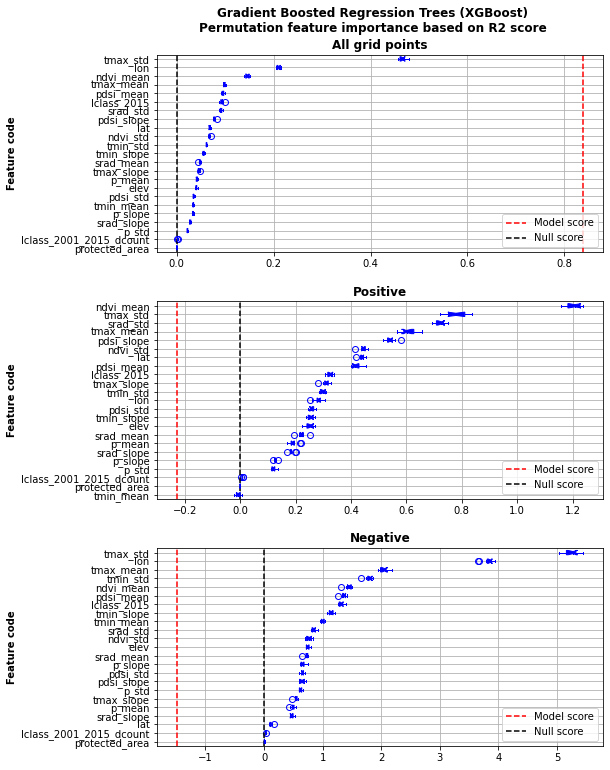

In [20]:
%%time

# Make figure.
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(8, 12), sharex=False)

# All grid points.
ax0.boxplot(
    notch=True,
    x=results.T,
    vert=False,
    labels=features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)
ax0.axvline(score, linestyle="--", color="red", label="Model score")

# Positive trends.
ax1.boxplot(
    notch=True,
    x=results_pos.T,
    vert=False,
    labels=features_ordered_pos,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)
ax1.axvline(score_pos, linestyle="--", color="red", label="Model score")

# Negative trends.
ax2.boxplot(
    notch=True,
    x=results_neg.T,
    vert=False,
    labels=features_ordered_neg,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)
ax2.axvline(score_neg, linestyle="--", color="red", label="Model score")

# Adjustments.
ax0.set_ylabel("Feature code", weight="bold")
ax1.set_ylabel("Feature code", weight="bold")
ax2.set_ylabel("Feature code", weight="bold")
plt.suptitle("Gradient Boosted Regression Trees (XGBoost)\n" + \
             "Permutation feature importance based on R2 score", weight="bold")
ax0.set_title("All grid points", weight="bold")
ax1.set_title("Positive", weight="bold")
ax2.set_title("Negative", weight="bold")
plt.subplots_adjust(hspace=0.25, top=0.925)
for axis in (ax0, ax1, ax2):
    axis.axvline(linestyle="--", color="black", label="Null score")
    axis.invert_yaxis()
    axis.grid()
    axis.legend(loc=4)
    
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_gbrt_xgboost_permutation_importances.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )    

## Partial dependence plots

>>> Processing tmax_std ...
>>> Processing lon ...
>>> Processing ndvi_mean ...
>>> Processing tmax_mean ...
>>> Processing pdsi_mean ...
>>> Processing lclass_2015 ...
>>> Processing srad_std ...
>>> Processing pdsi_slope ...
>>> Processing lat ...
CPU times: user 25min 40s, sys: 1min 10s, total: 26min 50s
Wall time: 1min 4s


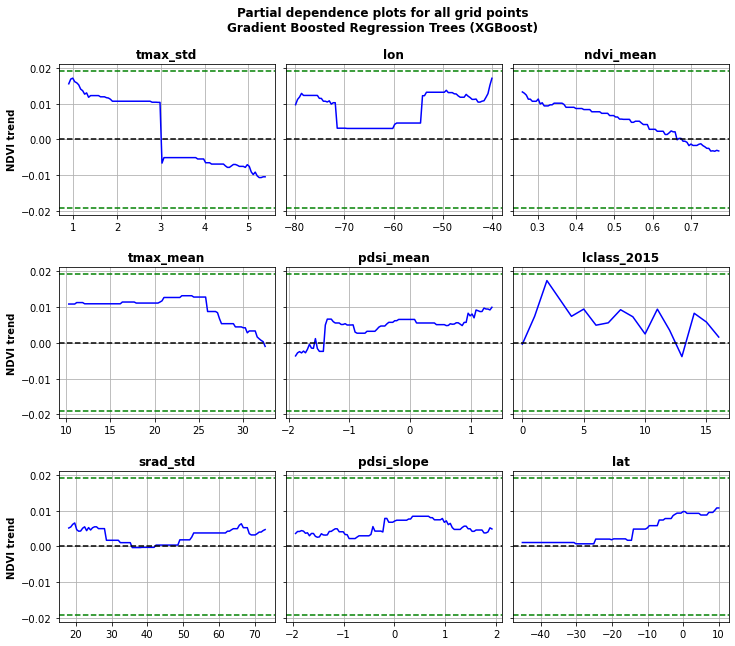

In [21]:
%%time

# Make figure.
fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharey=True)
axes = axes.flatten()

# The most important features.
for index, feature in enumerate(features_ordered[:9]):
    
    print(">>> Processing", feature, "...")    
    
    # Partial dependence of a feature (or a set of features) corresponds to
    # the average response of an estimator for each possible value of the
    # feature.
    pdp, fgrid = partial_dependence(
        estimator=final_model,
        X=df_matrix[features],
        features=[str(feature)],
        method="brute",
        percentiles=(0.05, 0.95),
        grid_resolution=100
    )
    
    # Skeleton plot.
    axes[index].plot(fgrid[0], pdp[0], "-b")
    axes[index].set_title(feature, weight="bold")
    axes[index].grid()
    axes[index].axhline(y=-u, lw=1.5, ls="--", color="green")
    axes[index].axhline(y=u, lw=1.5, ls="--", color="green")
    axes[index].axhline(y=0, lw=1.5, ls="--", color="black")
    
    
# Adjustments.    
plt.suptitle("Partial dependence plots for all grid points\n" + \
             "Gradient Boosted Regression Trees (XGBoost)",
             weight="bold")
plt.subplots_adjust(wspace=0.05, hspace=0.35, top=0.90)
axes[0].set_ylabel("NDVI trend", weight="bold")
axes[3].set_ylabel("NDVI trend", weight="bold")
_ = axes[6].set_ylabel("NDVI trend", weight="bold")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_gbrt_xgboost_partial_dependence_plots.jpg", 
        dpi=200, 
        bbox_inches="tight"
    ) 

## Predicted error distribution

CPU times: user 5.19 s, sys: 304 ms, total: 5.49 s
Wall time: 445 ms


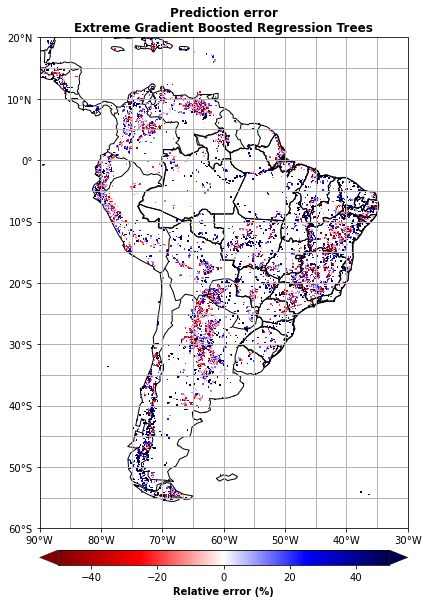

In [22]:
%%time

# Error = (Ytrue - Ypred) *100 / Ytrue.
sca = 1.10
axgr = cdlearn.maps.south_america(
    figsize=(6 * sca, 12 * sca), 
    nrows_ncols=(1, 1),
    axes_pad=0.05,
    titles=["Prediction error\nExtreme Gradient Boosted Regression Trees"],
    cbar_mode="single",
    cbar_location="bottom"
)

# As pandas DataFrame object.
num = (df_matrix[target].values.flatten() - final_model.predict(df_matrix[features]))
den = df_matrix[target].values.flatten()
error = 100 * np.divide(num, den, out=np.nan * np.ones_like(den), where=den!=0)
error = pd.DataFrame(data=error, columns=["error"])
error["lat"] = df_matrix["lat"].values
error["lon"] = df_matrix["lon"].values
error = error.set_index(keys=["lat", "lon"])

# Convert to xarray Dataset object.
error = error.to_xarray()

# Data on map.
p = error.error.plot(
    ax=axgr[0],
    vmin=-50,
    vmax=50,
    cmap=plt.cm.seismic_r,
    add_colorbar=False,
    add_labels=False
)

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="both")
cb.set_label_text("Relative error (%)", weight="bold") 

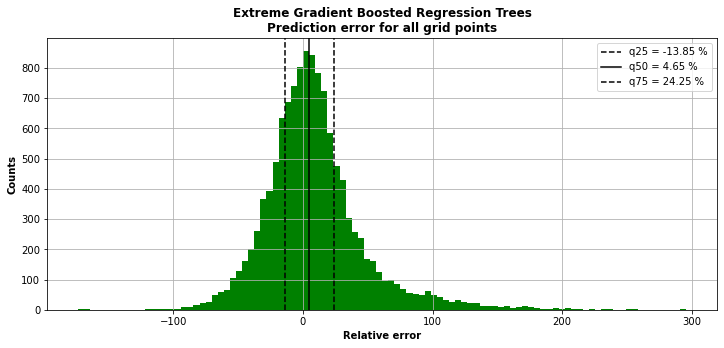

In [23]:
# Quantiles.
err = error.error.values.flatten()
err = err[~np.isnan(err)]
q25, q50, q75 = np.quantile(err, q=[0.25, 0.50, 0.75])

# Make figure.
plt.figure(figsize=(12, 5))
plt.hist(err, bins=100, color="green")
plt.axvline(x=q25, ls="--", color="black", label=str("q25 = %.2f %%" %(q25)))
plt.axvline(x=q50, ls="-", color="black", label=str("q50 = %.2f %%" %(q50)))
plt.axvline(x=q75, ls="--", color="black", label=str("q75 = %.2f %%" %(q75)))
plt.title("Extreme Gradient Boosted Regression Trees\nPrediction error for all grid points", 
          weight="bold")
plt.xlabel("Relative error", weight="bold")
plt.ylabel("Counts", weight="bold")
plt.legend()
plt.grid();

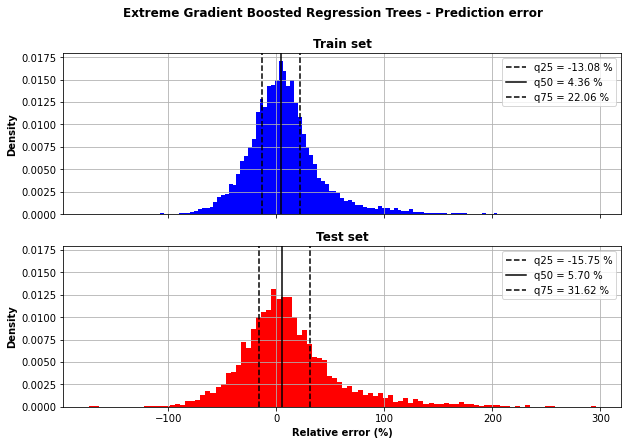

In [24]:
# Train error as pandas DataFrame object.
num = (df_y_train.ndvi_slope.values - final_model.predict(df_x_train))
den = df_y_train.ndvi_slope.values
error_train = 100 * np.divide(num, den, out=np.nan * np.ones_like(den), where=den!=0)

# Train error as pandas DataFrame object.
num = (df_y_test.ndvi_slope.values - final_model.predict(df_x_test))
den = df_y_test.ndvi_slope.values
error_test = 100 * np.divide(num, den, out=np.nan * np.ones_like(den), where=den!=0)

# Quantiles.
error_train = error_train[~np.isnan(error_train)]
error_test = error_test[~np.isnan(error_test)]
q25_train, q50_train, q75_train = np.quantile(error_train, q=[0.25, 0.50, 0.75])
q25_test, q50_test, q75_test = np.quantile(error_test, q=[0.25, 0.50, 0.75])

# Make figure.
fig, axes = plt.subplots(2, 1, figsize=(10, 6.5), sharex=True, sharey=True)
axes = axes.flatten()
axes[0].hist(error_train, bins=100, density=True, color="blue")
axes[1].hist(error_test, bins=100, density=True, color="red")
axes[0].axvline(x=q25_train, ls="--", color="black", label=str("q25 = %.2f %%" %(q25_train)))
axes[0].axvline(x=q50_train, ls="-", color="black", label=str("q50 = %.2f %%" %(q50_train)))
axes[0].axvline(x=q75_train, ls="--", color="black", label=str("q75 = %.2f %%" %(q75_train)))
axes[1].axvline(x=q25_test, ls="--", color="black", label=str("q25 = %.2f %%" %(q25_test)))
axes[1].axvline(x=q50_test, ls="-", color="black", label=str("q50 = %.2f %%" %(q50_test)))
axes[1].axvline(x=q75_test, ls="--", color="black", label=str("q75 = %.2f %%" %(q75_test)))
axes[1].set_xlabel("Relative error (%)", weight="bold")
axes[0].set_ylabel("Density", weight="bold")
axes[1].set_ylabel("Density", weight="bold")
axes[0].set_title("Train set", weight="bold")
axes[1].set_title("Test set", weight="bold")
axes[0].grid()
axes[1].grid()
axes[0].legend()
axes[1].legend()
_ = fig.suptitle(
    "Extreme Gradient Boosted Regression Trees - Prediction error", 
    weight="bold"
)